# 1. Define binning and model

In [1]:
import uproot
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import pyhf
import cabinetry
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [2]:
cabinetry.set_logging()

In [3]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.5 # 0.8 before adding fakeD
end = 4.2
num_bins = 40

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -3 # -1.1 before adding fakeD
end = 9.5 # 8.6 before adding fakeD
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)

bin_threshold = 1
# Check for empty bins
# empty_bins = [41, 42, 43, 44, 46, 47, 48, 49]

# Merge adjacent empty bins
# merged_bins = np.delete(bins, empty_bins)

# Define relevant variables
training_variables = util.training_variables

In [4]:
#################### Classify template samples  ##################
def sample_classifier(df_temp):
    DecayMode = {'bkg_fakeD':0,           'bkg_continuum':1,    'bkg_combinatorial':2,
                 'bkg_Odecay':3,          'bkg_fakeTC':4,       r'$D\tau\nu$':5,
                 r'$D^\ast\tau\nu$':6,    r'$D\ell\nu$':7,      r'$D^\ast\ell\nu$':8,
                 r'$D^{\ast\ast}\tau\nu$':[9,10],               r'res_$D^{\ast\ast}\ell\nu$':[11,14],
                 r'gap_non_$D^{\ast\ast}\ell\nu$':[12,13,15],   'bkg_others':16}

    templates = {}

    for name, mode in DecayMode.items():
        if type(DecayMode[name])==int:
            sample = df_temp.query(f'mode=={DecayMode[name]}')
            if len(sample)==0:
                continue
            else:
                templates[name] = sample
        elif type(DecayMode[name])==list:
            nModes = len(DecayMode[name])
            query_string = f'mode=={DecayMode[name][0]}'
            for i in range(nModes):
                if i==0:
                    continue
                else:
                    query_string += f' or mode=={DecayMode[name][i]}'
            sample = df_temp.query(query_string)
            if len(sample)==0:
                continue
            else:
                templates[name] = sample
        else:
            raise TypeError('Error: mode has to be an int or a list')
    return templates

In [49]:
#################### Load signals and fakeD from signal region ################
test_input_cut = '((5<=mode) & (mode<=15))|(mode==0)'
# test_input_cut = '(mode==0)'

columns = util.all_relevant_variables
# Load sig and fake D from signal region
test = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/subset_*.root:B0'],
                          library="np",
                          cut=test_input_cut,
                          filter_branch=lambda branch: branch.name in columns)
df_test = pd.DataFrame(test)
test_templates=sample_classifier(df_test)

#################### Create test 2d histograms ################

test_histograms = {}
test_staterr = {}
for name, df in test_templates.items():

    (counts, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                              df['p_D_l'],
                                              bins=[MM2_bins, p_D_l_bins],
                                              weights=df['__weight__'])

    (staterr_squared, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                                       df['p_D_l'],
                                                       bins=[MM2_bins, p_D_l_bins],
                                                       weights=df['__weight__']**2)
    test_histograms[name] = counts.T
    test_staterr[name] = np.sqrt(staterr_squared.T)

threshold_mask_1 = np.sum(list(test_histograms.values()),axis=0) >= bin_threshold

In [50]:
#################### Load signals and sideband fakeD ################
sig_input_cut = '((5<=mode) & (mode<=15))'

LS_input_cut = '(mode==0) & (D_M<1.84)'

RS_input_cut = '(mode==0) & (D_M>1.9)'

columns = util.all_relevant_variables
# Load sig and fake D from signal region and sideband
temp_sig = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/subset_*.root:B0'],
                          library="np",
                          cut=sig_input_cut,
                          filter_branch=lambda branch: branch.name in columns)

temp_fakeD_LS = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/Dsideband/subset_*.root:B0'],
                          library="np",
                          cut=LS_input_cut,
                          filter_branch=lambda branch: branch.name in columns)

temp_fakeD_RS = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/Dsideband/subset_*.root:B0'],
                          library="np",
                          cut=RS_input_cut,
                          filter_branch=lambda branch: branch.name in columns)

df_sig = pd.DataFrame(temp_sig)
df_fakeD_LS = pd.DataFrame(temp_fakeD_LS)
df_fakeD_RS = pd.DataFrame(temp_fakeD_RS)

In [51]:
df_temp = pd.concat([df_fakeD_LS, df_sig, df_fakeD_RS])
templates=sample_classifier(df_temp)

#################### Create template 2d histograms ################

t_histograms = {}
t_staterr = {}
for name, df in templates.items():

    (counts, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                              df['p_D_l'],
                                              bins=[MM2_bins, p_D_l_bins],
                                              weights=df['__weight__'])

    (staterr_squared, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                                       df['p_D_l'],
                                                       bins=[MM2_bins, p_D_l_bins],
                                                       weights=df['__weight__']**2)
    t_histograms[name] = counts.T
    t_staterr[name] = np.sqrt(staterr_squared.T)

################### Trimming and flattening ###############
# remove bins with count smaller than bin_threshold
threshold_mask_2 = np.sum(list(t_histograms.values()),axis=0) >= bin_threshold

threshold_mask_final = threshold_mask_1 & threshold_mask_2
template_flat = {name:t[threshold_mask_final].tolist() for name,t in t_histograms.items()}
staterr_flat = {name:se[threshold_mask_final].tolist() for name,se in t_staterr.items()}

asimov_data = np.sum(list(template_flat.values()),axis=0)
for name, hist in t_histograms.items():
    print(name, 'original template:',np.sum(hist), 'after mask:',np.sum(template_flat[name]))

bkg_fakeD original template: 308677.0 after mask: 307927.0
$D\tau\nu$ original template: 19644.0 after mask: 19644.0
$D^\ast\tau\nu$ original template: 9876.0 after mask: 9876.0
$D\ell\nu$ original template: 192101.0 after mask: 192101.0
$D^\ast\ell\nu$ original template: 125662.0 after mask: 125662.0
$D^{\ast\ast}\tau\nu$ original template: 5990.0 after mask: 5990.0
res_$D^{\ast\ast}\ell\nu$ original template: 115893.0 after mask: 115893.0
gap_non_$D^{\ast\ast}\ell\nu$ original template: 24375.0 after mask: 24375.0


In [52]:
################### Trimming and flattening for the signal region ###############
test_flat = {name:t[threshold_mask_final].tolist() for name,t in test_histograms.items()}
test_staterr_flat = {name:se[threshold_mask_final].tolist() for name,se in test_staterr.items()}
test_asimov_data = np.sum(list(test_flat.values()),axis=0)

################### Calculating the weight as SR/SB ###############
fakeD_weight = np.array(test_flat['bkg_fakeD']) / np.array(template_flat['bkg_fakeD'])
zero_weight_mask = fakeD_weight == 0

################### Applying the weight to the sideband counts and error ###############
template_flat['bkg_fakeD'] = ( np.array(template_flat['bkg_fakeD']) * fakeD_weight ).tolist()

staterr_flat_fakeD = np.array(staterr_flat['bkg_fakeD']) * fakeD_weight
staterr_flat_fakeD[zero_weight_mask] = 1        # assign 1 to the bins where count=0
staterr_flat['bkg_fakeD'] = staterr_flat_fakeD.tolist()

# 2. Create a pyhf workspace

In [58]:
workspace_path = "R_D_2d_workspace_withDsideband.json"
spec = cabinetry.workspace.load(workspace_path)
spec_test = cabinetry.workspace.load('../Toys_pipeline/R_D_2d_workspace_withFakeDinSR_forSidebandTest.json')
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "electron",
            "samples": [
                {
                    "data": [
                        1.6071428571428572,
                        6.334033613445377,
                        6.8697478991596626,
                        9.453781512605042,
                        17.36344537815127,
                        9.485294117647062,
                        1.6071428571428572,
                        3.214285714285714,
                        5.892857142857142,
                        10.619747899159666,
                        18.088235294117656,
                        28.10924369747898,
                        27.510504201680664,
                        31.071428571428548,
                        21.554621848739497,
                        2.6785714285714284,
                        4.821428571428571,
                        8.918067226890756,
                        11.060924369747902,
                        24.80042016806

In [59]:
# update templates and data in the workspace
# signal region
names = list(template_flat.keys())
for i, sample_SignalRegion in enumerate(spec['channels'][0]['samples']):
    spec['channels'][0]['samples'][i]['name'] = names[i]
    spec['channels'][0]['samples'][i]['data'] = template_flat[names[i]]
    for j,m in enumerate(sample_SignalRegion['modifiers']):
        if m['type']=='staterror':
#             spec['channels'][0]['samples'][i]['modifiers'].remove(m)
            spec['channels'][0]['samples'][i]['modifiers'][j]['data'] = staterr_flat[names[i]]
            spec['channels'][0]['samples'][i]['modifiers'][j]['name'] = 'staterror_signal_region'
        elif m['type']=="normfactor":
            spec['channels'][0]['samples'][i]['modifiers'][j]['name'] = names[i]+'_norm'
        else:
            print(m['type'],'is turned on')

# D sideband
# for i in [1,2]:
#     Dsideband = spec['channels'][i]['samples'][0]
#     if i==1:
#         Dsideband['data']=template_flat_Dlsb['bkg_fakeD']
#         Dsideband['name']='D_sideband_Left'
#     else:
#         Dsideband['data']=template_flat_Drsb['bkg_fakeD']
#         Dsideband['name']='D_sideband_Right'
#     for m in Dsideband['modifiers']:
#         if m['type']=='staterror' and i==1:
#             m['data'] = staterr_flat_Dlsb['bkg_fakeD']
#             m['name'] = 'staterror_Dsideband_Left'
#         if m['type']=='staterror' and i==2:
#             m['data'] = staterr_flat_Drsb['bkg_fakeD']
#             m['name'] = 'staterror_Dsideband_Right'
#         if m['type']=="normfactor":
#             m['name'] = 'bkg_fakeD_norm'

            
spec['observations'][0]['data']=asimov_data.tolist()
# spec['observations'][1]['data']=data_flat_Dlsb
# spec['observations'][2]['data']=data_flat_Drsb

for i, par in enumerate(spec["measurements"][0]["config"]["parameters"]):
    par['name']=names[i]+'_norm'
    par['bounds'] = [[-1,1]]
    par['inits'] = [0.12]
    if par['name']=='bkg_fakeD_norm':
        par['bounds'] = [[0,1]]
    
spec["measurements"][0]["config"]['poi']="$D\\tau\\nu$_norm"

print(json.dumps(spec, sort_keys=True, indent=4))

# cabinetry.workspace.save(spec, 'R_D_2d_workspace_withDsideband.json')

{
    "channels": [
        {
            "name": "electron",
            "samples": [
                {
                    "data": [
                        1.0,
                        3.0,
                        7.0,
                        11.0,
                        14.0,
                        18.0,
                        1.0,
                        2.0,
                        6.0,
                        8.0,
                        19.0,
                        31.0,
                        31.0,
                        35.0,
                        25.0,
                        0.0,
                        2.0,
                        6.0,
                        11.0,
                        14.0,
                        18.0,
                        40.0,
                        61.0,
                        53.0,
                        68.0,
                        65.0,
                        33.0,
                        1.0,
                        2.0,
       

In [60]:
# update templates and data in the workspace
# signal region
names = list(test_flat.keys())
for i, sample_SignalRegion in enumerate(spec_test['channels'][0]['samples']):
    spec_test['channels'][0]['samples'][i]['name'] = names[i]
    spec_test['channels'][0]['samples'][i]['data'] = test_flat[names[i]]
    for j,m in enumerate(sample_SignalRegion['modifiers']):
        if m['type']=='staterror':
#             spec_test['channels'][0]['samples'][i]['modifiers'].remove(m)
            spec_test['channels'][0]['samples'][i]['modifiers'][j]['data'] = test_staterr_flat[names[i]]
            spec_test['channels'][0]['samples'][i]['modifiers'][j]['name'] = 'staterror_signal_region'
        elif m['type']=="normfactor":
            spec_test['channels'][0]['samples'][i]['modifiers'][j]['name'] = names[i]+'_norm'
        else:
            print(m['type'],'is turned on')

            
spec_test['observations'][0]['data']=test_asimov_data.tolist()

for i, par in enumerate(spec_test["measurements"][0]["config"]["parameters"]):
    par['name']=names[i]+'_norm'
    par['bounds'] = [[-1,1]]
    par['inits'] = [0.12]
    if par['name']=='bkg_fakeD_norm':
        par['bounds'] = [[0,1]]
    
spec_test["measurements"][0]["config"]['poi']="$D\\tau\\nu$_norm"

# print(json.dumps(spec_test, sort_keys=True, indent=4))

# cabinetry.workspace.save(spec_test, '../Toys_pipeline/R_D_2d_workspace_withFakeDinSR_forSidebandTest.json')

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier gap_non_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier res_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (789 new nuisance parameters)
INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


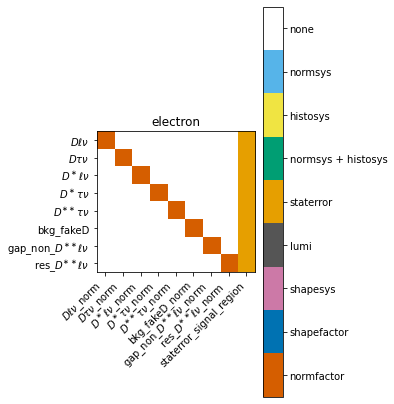

In [61]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

In [62]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier gap_non_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier res_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (789 new nuisance parameters)


In [63]:

model_test, data_test = cabinetry.model_utils.model_and_data(spec_test)

# set initialisation for generating the asimov sample       
toy_pars = model_test.config.suggested_init()
toy_pars[:8] = [0.12]*8
# generate the toys:
pdf_toy = model_test.make_pdf(pyhf.tensorlib.astensor(toy_pars))

toys = pdf_toy.sample((5,))

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier gap_non_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier res_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (789 new nuisance parameters)


In [71]:
cabinetry.workspace.save(spec, '../Toys_pipeline/R_D_2d_workspace_withDsideband_reweight.json')
cabinetry.workspace.save(spec_test, '../Toys_pipeline/R_D_2d_workspace_withFakeDinSR_forSidebandTest_reweight.json')

DEBUG - cabinetry.workspace - saving workspace to ../Toys_pipeline/R_D_2d_workspace_withDsideband_reweight.json
DEBUG - cabinetry.workspace - saving workspace to ../Toys_pipeline/R_D_2d_workspace_withFakeDinSR_forSidebandTest_reweight.json


DEBUG - cabinetry.model_utils - total stdev is [[1.17, 1.5, 1.64, 1.5, 2.01, 1.77, ..., 0.959, 1.48, 3.77, 5.77, 5.89, 4.17]]
DEBUG - cabinetry.model_utils - total stdev per channel is [238]
INFO - cabinetry.visualize.utils - saving figure as figures/electron_prefit.pdf


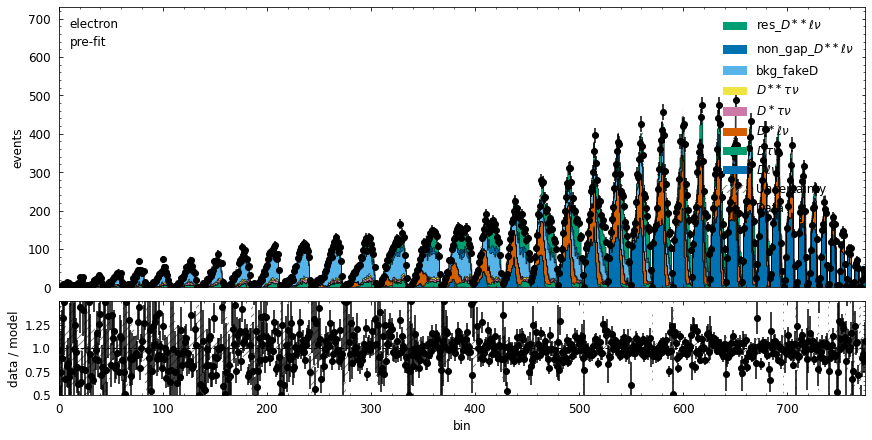

In [29]:
model_pred_prefit = cabinetry.model_utils.prediction(model)
#plt.figure(figsize=(16,6))
dms = cabinetry.visualize.data_mc(model_pred_prefit, data, log_scale=False)
for i in dms:
    i['figure'].set_figwidth(12)

# 3. MLE

In [64]:
toys[0].tolist()

[0.0,
 0.0,
 0.0,
 2.0,
 3.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 3.0,
 8.0,
 3.0,
 2.0,
 4.0,
 0.0,
 1.0,
 1.0,
 2.0,
 2.0,
 5.0,
 7.0,
 10.0,
 6.0,
 9.0,
 6.0,
 2.0,
 0.0,
 1.0,
 0.0,
 5.0,
 2.0,
 3.0,
 5.0,
 5.0,
 14.0,
 8.0,
 12.0,
 9.0,
 10.0,
 1.0,
 0.0,
 0.0,
 1.0,
 4.0,
 1.0,
 9.0,
 7.0,
 10.0,
 15.0,
 20.0,
 26.0,
 24.0,
 19.0,
 15.0,
 2.0,
 0.0,
 0.0,
 1.0,
 0.0,
 6.0,
 1.0,
 6.0,
 5.0,
 17.0,
 12.0,
 17.0,
 29.0,
 35.0,
 31.0,
 21.0,
 21.0,
 3.0,
 0.0,
 0.0,
 3.0,
 2.0,
 3.0,
 4.0,
 5.0,
 5.0,
 14.0,
 20.0,
 23.0,
 38.0,
 32.0,
 42.0,
 40.0,
 43.0,
 43.0,
 21.0,
 3.0,
 0.0,
 1.0,
 2.0,
 1.0,
 5.0,
 10.0,
 12.0,
 8.0,
 11.0,
 19.0,
 23.0,
 32.0,
 37.0,
 54.0,
 57.0,
 49.0,
 59.0,
 45.0,
 18.0,
 4.0,
 0.0,
 0.0,
 2.0,
 2.0,
 7.0,
 10.0,
 5.0,
 12.0,
 17.0,
 29.0,
 28.0,
 38.0,
 51.0,
 72.0,
 68.0,
 69.0,
 84.0,
 53.0,
 29.0,
 8.0,
 0.0,
 0.0,
 0.0,
 5.0,
 5.0,
 4.0,
 7.0,
 14.0,
 13.0,
 18.0,
 16.0,
 24.0,
 30.0,
 50.0,
 68.0,
 64.0,
 87.0,
 87.0,
 77.0,
 66.0,
 57.0,
 21.0,
 0.0,


In [ ]:
%%time
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])

In [70]:
%%time
## before adding fakeD
fix_par = [False,False,False,False,False,True]
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
fit_results = cabinetry.fit.fit(model=model, data=toys[2],
                               fix_pars=fix_par)#, minos=model.config.parameters[:7])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1747                       │      Nfcn = 322630, Ngrad = 26       │
│ EDM = 0.000232 (Goal: 0.0002)    │           time = 206.6 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.fit - staterror_signal_region[82]        =  1.1759 +/- 0.0618
INFO - cabinetry.fit - staterror_signal_region[83]        =  0.9746 +/- 0.0526
INFO - cabinetry.fit - staterror_signal_region[84]        =  0.9816 +/- 0.0468
INFO - cabinetry.fit - staterror_signal_region[85]        =  1.0769 +/- 0.0434
INFO - cabinetry.fit - staterror_signal_region[86]        =  1.0071 +/- 0.0402
INFO - cabinetry.fit - staterror_signal_region[87]        =  0.9484 +/- 0.0406
INFO - cabinetry.fit - staterror_signal_region[88]        =  1.0187 +/- 0.0422
INFO - cabinetry.fit - staterror_signal_region[89]        =  0.9420 +/- 0.0476
INFO - cabinetry.fit - staterror_signal_region[90]        =  0.9911 +/- 0.0657
INFO - cabinetry.fit - staterror_signal_region[91]        =  0.6869 +/- 0.0956
INFO - cabinetry.fit - staterror_signal_region[92]        =  1.0272 +/- 1.3636
INFO - cabinetry.fit - staterror_signal_region[93]        =  0.9444 +/- 0.2757
INFO - cabinetry.fit - staterror_signal_region[94]  

INFO - cabinetry.fit - staterror_signal_region[186]       =  0.9920 +/- 0.0563
INFO - cabinetry.fit - staterror_signal_region[187]       =  1.0601 +/- 0.0482
INFO - cabinetry.fit - staterror_signal_region[188]       =  0.9991 +/- 0.0425
INFO - cabinetry.fit - staterror_signal_region[189]       =  1.0587 +/- 0.0395
INFO - cabinetry.fit - staterror_signal_region[190]       =  0.9943 +/- 0.0344
INFO - cabinetry.fit - staterror_signal_region[191]       =  0.9988 +/- 0.0325
INFO - cabinetry.fit - staterror_signal_region[192]       =  1.0772 +/- 0.0283
INFO - cabinetry.fit - staterror_signal_region[193]       =  0.9867 +/- 0.0268
INFO - cabinetry.fit - staterror_signal_region[194]       =  0.9529 +/- 0.0257
INFO - cabinetry.fit - staterror_signal_region[195]       =  1.0126 +/- 0.0258
INFO - cabinetry.fit - staterror_signal_region[196]       =  0.9469 +/- 0.0269
INFO - cabinetry.fit - staterror_signal_region[197]       =  0.9971 +/- 0.0275
INFO - cabinetry.fit - staterror_signal_region[198] 

INFO - cabinetry.fit - staterror_signal_region[290]       =  0.9987 +/- 0.0277
INFO - cabinetry.fit - staterror_signal_region[291]       =  0.9783 +/- 0.0268
INFO - cabinetry.fit - staterror_signal_region[292]       =  0.9918 +/- 0.0245
INFO - cabinetry.fit - staterror_signal_region[293]       =  0.9841 +/- 0.0236
INFO - cabinetry.fit - staterror_signal_region[294]       =  0.9808 +/- 0.0236
INFO - cabinetry.fit - staterror_signal_region[295]       =  1.0475 +/- 0.0235
INFO - cabinetry.fit - staterror_signal_region[296]       =  1.0055 +/- 0.0226
INFO - cabinetry.fit - staterror_signal_region[297]       =  1.0145 +/- 0.0226
INFO - cabinetry.fit - staterror_signal_region[298]       =  0.9950 +/- 0.0231
INFO - cabinetry.fit - staterror_signal_region[299]       =  1.0292 +/- 0.0239
INFO - cabinetry.fit - staterror_signal_region[300]       =  1.0281 +/- 0.0267
INFO - cabinetry.fit - staterror_signal_region[301]       =  1.0246 +/- 0.0364
INFO - cabinetry.fit - staterror_signal_region[302] 

INFO - cabinetry.fit - staterror_signal_region[394]       =  1.0153 +/- 0.0349
INFO - cabinetry.fit - staterror_signal_region[395]       =  0.9905 +/- 0.0284
INFO - cabinetry.fit - staterror_signal_region[396]       =  1.0025 +/- 0.0248
INFO - cabinetry.fit - staterror_signal_region[397]       =  1.0526 +/- 0.0222
INFO - cabinetry.fit - staterror_signal_region[398]       =  0.9893 +/- 0.0202
INFO - cabinetry.fit - staterror_signal_region[399]       =  0.9846 +/- 0.0189
INFO - cabinetry.fit - staterror_signal_region[400]       =  1.0183 +/- 0.0183
INFO - cabinetry.fit - staterror_signal_region[401]       =  0.9965 +/- 0.0188
INFO - cabinetry.fit - staterror_signal_region[402]       =  1.0130 +/- 0.0193
INFO - cabinetry.fit - staterror_signal_region[403]       =  1.0553 +/- 0.0199
INFO - cabinetry.fit - staterror_signal_region[404]       =  1.0166 +/- 0.0200
INFO - cabinetry.fit - staterror_signal_region[405]       =  0.9954 +/- 0.0204
INFO - cabinetry.fit - staterror_signal_region[406] 

INFO - cabinetry.fit - staterror_signal_region[498]       =  1.0604 +/- 0.0899
INFO - cabinetry.fit - staterror_signal_region[499]       =  1.0415 +/- 0.0724
INFO - cabinetry.fit - staterror_signal_region[500]       =  0.9472 +/- 0.0495
INFO - cabinetry.fit - staterror_signal_region[501]       =  0.9679 +/- 0.0328
INFO - cabinetry.fit - staterror_signal_region[502]       =  0.9627 +/- 0.0263
INFO - cabinetry.fit - staterror_signal_region[503]       =  0.9958 +/- 0.0238
INFO - cabinetry.fit - staterror_signal_region[504]       =  0.9784 +/- 0.0205
INFO - cabinetry.fit - staterror_signal_region[505]       =  1.0478 +/- 0.0187
INFO - cabinetry.fit - staterror_signal_region[506]       =  1.0283 +/- 0.0168
INFO - cabinetry.fit - staterror_signal_region[507]       =  0.9989 +/- 0.0156
INFO - cabinetry.fit - staterror_signal_region[508]       =  0.9922 +/- 0.0148
INFO - cabinetry.fit - staterror_signal_region[509]       =  1.0216 +/- 0.0144
INFO - cabinetry.fit - staterror_signal_region[510] 

INFO - cabinetry.fit - staterror_signal_region[602]       =  0.9844 +/- 0.0252
INFO - cabinetry.fit - staterror_signal_region[603]       =  0.9252 +/- 0.0429
INFO - cabinetry.fit - staterror_signal_region[604]       =  1.1109 +/- 0.1665
INFO - cabinetry.fit - staterror_signal_region[605]       =  1.0218 +/- 0.1608
INFO - cabinetry.fit - staterror_signal_region[606]       =  1.2660 +/- 0.1472
INFO - cabinetry.fit - staterror_signal_region[607]       =  0.9085 +/- 0.1382
INFO - cabinetry.fit - staterror_signal_region[608]       =  0.9638 +/- 0.1101
INFO - cabinetry.fit - staterror_signal_region[609]       =  0.8767 +/- 0.1017
INFO - cabinetry.fit - staterror_signal_region[610]       =  0.9287 +/- 0.0760
INFO - cabinetry.fit - staterror_signal_region[611]       =  1.0404 +/- 0.0412
INFO - cabinetry.fit - staterror_signal_region[612]       =  0.9900 +/- 0.0250
INFO - cabinetry.fit - staterror_signal_region[613]       =  0.9891 +/- 0.0209
INFO - cabinetry.fit - staterror_signal_region[614] 

INFO - cabinetry.fit - staterror_signal_region[706]       =  0.9632 +/- 0.0191
INFO - cabinetry.fit - staterror_signal_region[707]       =  0.9718 +/- 0.0173
INFO - cabinetry.fit - staterror_signal_region[708]       =  1.0065 +/- 0.0173
INFO - cabinetry.fit - staterror_signal_region[709]       =  0.9837 +/- 0.0269
INFO - cabinetry.fit - staterror_signal_region[710]       =  0.8548 +/- 0.0898
INFO - cabinetry.fit - staterror_signal_region[711]       =  0.7636 +/- 0.4451
INFO - cabinetry.fit - staterror_signal_region[712]       =  1.0289 +/- 0.5827
INFO - cabinetry.fit - staterror_signal_region[713]       =  0.9813 +/- 0.4083
INFO - cabinetry.fit - staterror_signal_region[714]       =  1.1060 +/- 0.3396
INFO - cabinetry.fit - staterror_signal_region[715]       =  0.8625 +/- 0.2828
INFO - cabinetry.fit - staterror_signal_region[716]       =  1.3578 +/- 0.2471
INFO - cabinetry.fit - staterror_signal_region[717]       =  0.8847 +/- 0.1955
INFO - cabinetry.fit - staterror_signal_region[718] 

CPU times: user 5min 26s, sys: 4.69 s, total: 5min 31s
Wall time: 5min 3s


In [69]:
%%time
## before adding fakeD
fix_par = [False,False,False,False,False,False]
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
fit_results = cabinetry.fit.fit(model=model, data=toys[2],
                               fix_pars=fix_par)#, minos=model.config.parameters[:7])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1747                       │      Nfcn = 323434, Ngrad = 23       │
│ EDM = 0.000736 (Goal: 0.0002)    │           time = 211.1 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.fit - staterror_signal_region[82]        =  1.1758 +/- 0.0619
INFO - cabinetry.fit - staterror_signal_region[83]        =  0.9744 +/- 0.0526
INFO - cabinetry.fit - staterror_signal_region[84]        =  0.9813 +/- 0.0468
INFO - cabinetry.fit - staterror_signal_region[85]        =  1.0766 +/- 0.0434
INFO - cabinetry.fit - staterror_signal_region[86]        =  1.0068 +/- 0.0402
INFO - cabinetry.fit - staterror_signal_region[87]        =  0.9483 +/- 0.0406
INFO - cabinetry.fit - staterror_signal_region[88]        =  1.0185 +/- 0.0422
INFO - cabinetry.fit - staterror_signal_region[89]        =  0.9418 +/- 0.0476
INFO - cabinetry.fit - staterror_signal_region[90]        =  0.9908 +/- 0.0657
INFO - cabinetry.fit - staterror_signal_region[91]        =  0.6864 +/- 0.0956
INFO - cabinetry.fit - staterror_signal_region[92]        =  1.0265 +/- 1.3636
INFO - cabinetry.fit - staterror_signal_region[93]        =  0.9440 +/- 0.2756
INFO - cabinetry.fit - staterror_signal_region[94]  

INFO - cabinetry.fit - staterror_signal_region[186]       =  0.9921 +/- 0.0563
INFO - cabinetry.fit - staterror_signal_region[187]       =  1.0601 +/- 0.0482
INFO - cabinetry.fit - staterror_signal_region[188]       =  0.9990 +/- 0.0425
INFO - cabinetry.fit - staterror_signal_region[189]       =  1.0587 +/- 0.0395
INFO - cabinetry.fit - staterror_signal_region[190]       =  0.9941 +/- 0.0344
INFO - cabinetry.fit - staterror_signal_region[191]       =  0.9991 +/- 0.0326
INFO - cabinetry.fit - staterror_signal_region[192]       =  1.0771 +/- 0.0283
INFO - cabinetry.fit - staterror_signal_region[193]       =  0.9868 +/- 0.0268
INFO - cabinetry.fit - staterror_signal_region[194]       =  0.9529 +/- 0.0257
INFO - cabinetry.fit - staterror_signal_region[195]       =  1.0125 +/- 0.0258
INFO - cabinetry.fit - staterror_signal_region[196]       =  0.9470 +/- 0.0269
INFO - cabinetry.fit - staterror_signal_region[197]       =  0.9972 +/- 0.0275
INFO - cabinetry.fit - staterror_signal_region[198] 

INFO - cabinetry.fit - staterror_signal_region[290]       =  0.9986 +/- 0.0277
INFO - cabinetry.fit - staterror_signal_region[291]       =  0.9783 +/- 0.0268
INFO - cabinetry.fit - staterror_signal_region[292]       =  0.9917 +/- 0.0245
INFO - cabinetry.fit - staterror_signal_region[293]       =  0.9840 +/- 0.0236
INFO - cabinetry.fit - staterror_signal_region[294]       =  0.9809 +/- 0.0236
INFO - cabinetry.fit - staterror_signal_region[295]       =  1.0476 +/- 0.0235
INFO - cabinetry.fit - staterror_signal_region[296]       =  1.0056 +/- 0.0226
INFO - cabinetry.fit - staterror_signal_region[297]       =  1.0145 +/- 0.0226
INFO - cabinetry.fit - staterror_signal_region[298]       =  0.9950 +/- 0.0231
INFO - cabinetry.fit - staterror_signal_region[299]       =  1.0293 +/- 0.0239
INFO - cabinetry.fit - staterror_signal_region[300]       =  1.0283 +/- 0.0267
INFO - cabinetry.fit - staterror_signal_region[301]       =  1.0247 +/- 0.0364
INFO - cabinetry.fit - staterror_signal_region[302] 

INFO - cabinetry.fit - staterror_signal_region[394]       =  1.0151 +/- 0.0349
INFO - cabinetry.fit - staterror_signal_region[395]       =  0.9904 +/- 0.0284
INFO - cabinetry.fit - staterror_signal_region[396]       =  1.0025 +/- 0.0248
INFO - cabinetry.fit - staterror_signal_region[397]       =  1.0526 +/- 0.0222
INFO - cabinetry.fit - staterror_signal_region[398]       =  0.9893 +/- 0.0202
INFO - cabinetry.fit - staterror_signal_region[399]       =  0.9846 +/- 0.0189
INFO - cabinetry.fit - staterror_signal_region[400]       =  1.0183 +/- 0.0183
INFO - cabinetry.fit - staterror_signal_region[401]       =  0.9965 +/- 0.0188
INFO - cabinetry.fit - staterror_signal_region[402]       =  1.0129 +/- 0.0193
INFO - cabinetry.fit - staterror_signal_region[403]       =  1.0553 +/- 0.0199
INFO - cabinetry.fit - staterror_signal_region[404]       =  1.0166 +/- 0.0200
INFO - cabinetry.fit - staterror_signal_region[405]       =  0.9953 +/- 0.0204
INFO - cabinetry.fit - staterror_signal_region[406] 

INFO - cabinetry.fit - staterror_signal_region[498]       =  1.0597 +/- 0.0899
INFO - cabinetry.fit - staterror_signal_region[499]       =  1.0410 +/- 0.0724
INFO - cabinetry.fit - staterror_signal_region[500]       =  0.9469 +/- 0.0495
INFO - cabinetry.fit - staterror_signal_region[501]       =  0.9678 +/- 0.0328
INFO - cabinetry.fit - staterror_signal_region[502]       =  0.9626 +/- 0.0263
INFO - cabinetry.fit - staterror_signal_region[503]       =  0.9957 +/- 0.0238
INFO - cabinetry.fit - staterror_signal_region[504]       =  0.9783 +/- 0.0205
INFO - cabinetry.fit - staterror_signal_region[505]       =  1.0478 +/- 0.0187
INFO - cabinetry.fit - staterror_signal_region[506]       =  1.0284 +/- 0.0168
INFO - cabinetry.fit - staterror_signal_region[507]       =  0.9990 +/- 0.0156
INFO - cabinetry.fit - staterror_signal_region[508]       =  0.9923 +/- 0.0148
INFO - cabinetry.fit - staterror_signal_region[509]       =  1.0216 +/- 0.0144
INFO - cabinetry.fit - staterror_signal_region[510] 

INFO - cabinetry.fit - staterror_signal_region[602]       =  0.9844 +/- 0.0252
INFO - cabinetry.fit - staterror_signal_region[603]       =  0.9251 +/- 0.0429
INFO - cabinetry.fit - staterror_signal_region[604]       =  1.1102 +/- 0.1665
INFO - cabinetry.fit - staterror_signal_region[605]       =  1.0213 +/- 0.1608
INFO - cabinetry.fit - staterror_signal_region[606]       =  1.2655 +/- 0.1472
INFO - cabinetry.fit - staterror_signal_region[607]       =  0.9080 +/- 0.1382
INFO - cabinetry.fit - staterror_signal_region[608]       =  0.9630 +/- 0.1101
INFO - cabinetry.fit - staterror_signal_region[609]       =  0.8762 +/- 0.1017
INFO - cabinetry.fit - staterror_signal_region[610]       =  0.9283 +/- 0.0760
INFO - cabinetry.fit - staterror_signal_region[611]       =  1.0402 +/- 0.0413
INFO - cabinetry.fit - staterror_signal_region[612]       =  0.9899 +/- 0.0250
INFO - cabinetry.fit - staterror_signal_region[613]       =  0.9891 +/- 0.0209
INFO - cabinetry.fit - staterror_signal_region[614] 

INFO - cabinetry.fit - staterror_signal_region[706]       =  0.9633 +/- 0.0191
INFO - cabinetry.fit - staterror_signal_region[707]       =  0.9719 +/- 0.0173
INFO - cabinetry.fit - staterror_signal_region[708]       =  1.0066 +/- 0.0173
INFO - cabinetry.fit - staterror_signal_region[709]       =  0.9836 +/- 0.0269
INFO - cabinetry.fit - staterror_signal_region[710]       =  0.8547 +/- 0.0898
INFO - cabinetry.fit - staterror_signal_region[711]       =  0.7624 +/- 0.4451
INFO - cabinetry.fit - staterror_signal_region[712]       =  1.0273 +/- 0.5827
INFO - cabinetry.fit - staterror_signal_region[713]       =  0.9806 +/- 0.4082
INFO - cabinetry.fit - staterror_signal_region[714]       =  1.1056 +/- 0.3396
INFO - cabinetry.fit - staterror_signal_region[715]       =  0.8620 +/- 0.2828
INFO - cabinetry.fit - staterror_signal_region[716]       =  1.3570 +/- 0.2471
INFO - cabinetry.fit - staterror_signal_region[717]       =  0.8847 +/- 0.1955
INFO - cabinetry.fit - staterror_signal_region[718] 

CPU times: user 5min 31s, sys: 4.83 s, total: 5min 36s
Wall time: 5min 8s


In [ ]:
%%time
pyhf.set_backend('numpy','scipy')
parameters = pyhf.infer.mle.fit(data=data, pdf=model)
fit_results = cabinetry.fit.fit(model=model, data=data,init_pars=list(parameters),)
                                #minos=model.config.parameters[:7])

In [ ]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


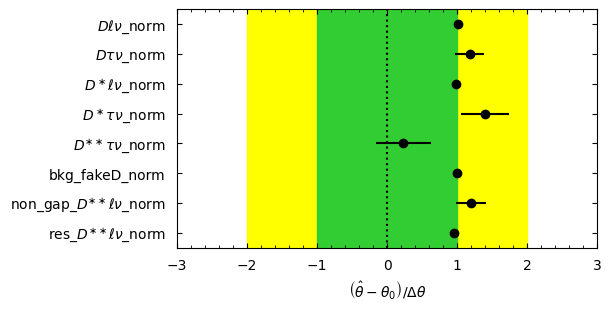

In [7]:
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


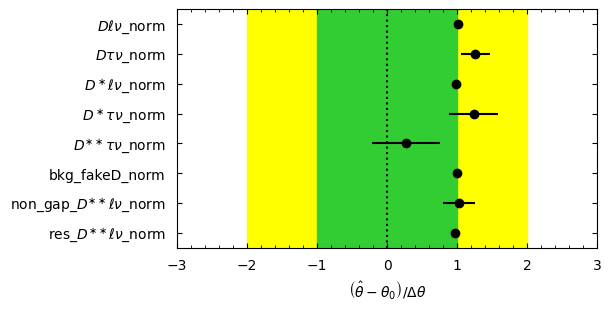

In [19]:
## after changing the fitting region
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


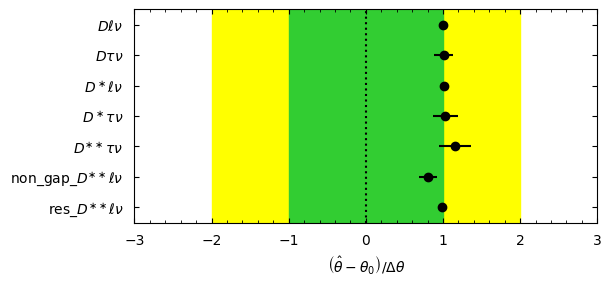

In [12]:
# gap * 0.5
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


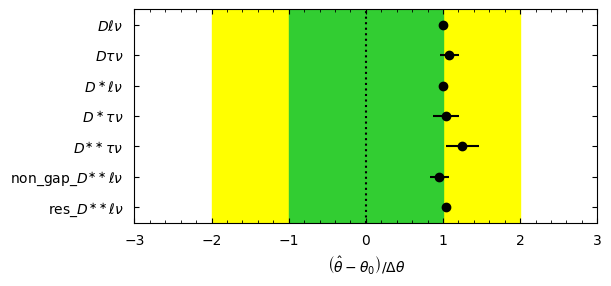

In [19]:
# gap * 1.5
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


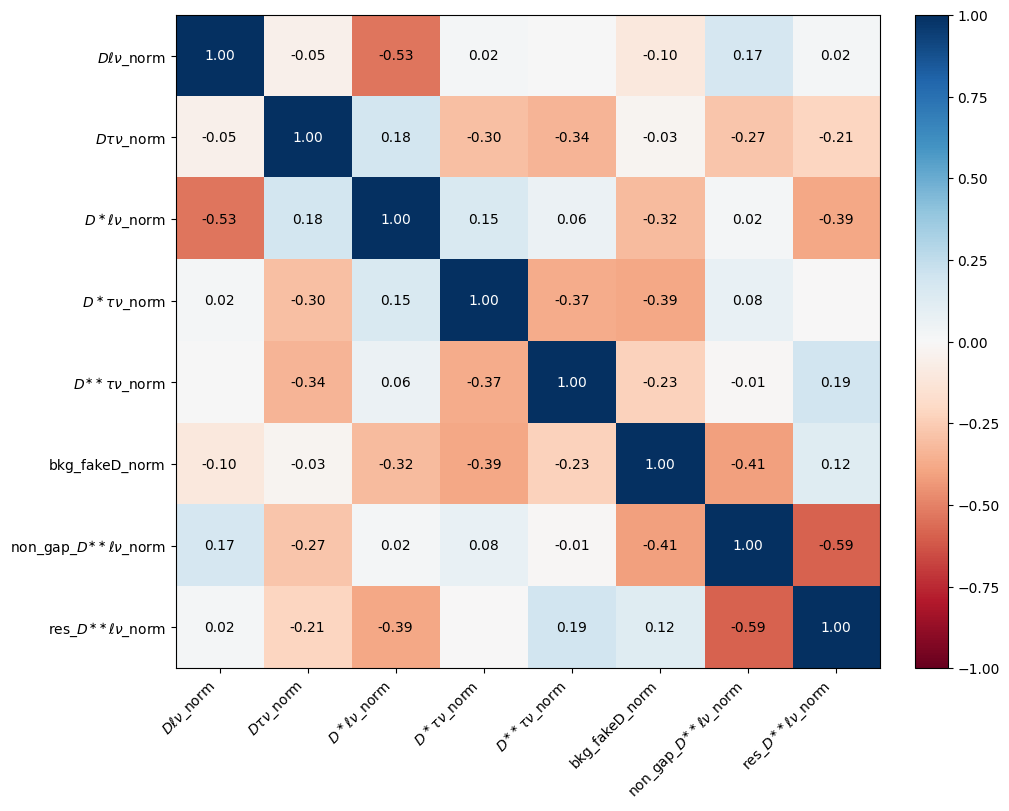

In [20]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.3)

In [31]:
# model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, log_scale=False)

TypeError: __init__() missing 1 required positional argument: 'dtype'

In [ ]:
templates = np.array([s['data'] for s in electron_channel['samples']])
counts=np.sum(test0,axis=0).reshape(41,47)

start = 0.8
end = 4.2
num_bins = 40
yedges = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -1.1
end = 8.6
num_bins = 50
xedges = np.linspace(start, end, num_bins + 1)

templates_2d = [t.reshape(counts.shape) for t in templates]
data_2d = counts

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,1.5],direction='p_D_l',plot_with='pltbar')

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,2.5],direction='mm2',plot_with='pltbar')

# 4. Asimov and Toys

In [ ]:
asimov_data = cabinetry.model_utils.asimov_data(model)
_ = cabinetry.fit.fit(model, asimov_data)

In [5]:
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
poi = model.config.parameters[:6]

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
pyhf.set_backend("numpy", 'minuit')

# init the norm parameters
par_bounds = model.config.suggested_bounds()
fixed_params = model.config.suggested_fixed()
poi = model.config.parameters[:6] # same as model.config.par_order

In [5]:
from multiprocessing import Pool

def fit_toys(toy):
    try:
        return cabinetry.fit.fit(model=model, data=toy)
        # return pyhf.infer.mle.fit(toy, model,return_uncertainties=True)
    except pyhf.exceptions.FailedMinimization:
        pass

def generate_toys(init_norm=None, n_toys=100, poi=poi,seed=0):
    # initialize the generator and model
    toy_pars = model.config.suggested_init()
    rng = np.random.default_rng(seed)
    toy_pars[:len(poi)] = rng.random(len(poi))
    if type(init_norm) in [int, float]:
        toy_pars[:len(poi)] = [init_norm]*len(poi)
    # print(f"init parameters: {list(zip(model.config.parameters, [round(n,2) for n in toy_pars]))}")

    # make the pdfs
    pdf_toy = model.make_pdf(pyhf.tensorlib.astensor(toy_pars))

    # draws samples from the pdf shape given the number of samples N=(10000,)
    return pdf_toy.sample((n_toys,)), toy_pars

def pull_plot(init_norm=None, n_toys=100, poi=poi):
    # create toys
    toys, toy_pars = generate_toys(init_norm=init_norm, n_toys=n_toys)
    
    # fit toys
    with Pool(None, maxtasksperchild=1) as p:
        fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))
    
    bestfit = np.array([f.bestfit for f in fit_results])
    errors = np.array([f.uncertainty for f in fit_results])
    
    # calculate pulls
    pulls = np.array(
        [
                (bestfit[:,model.config.par_slice(k)] - toy_pars[model.config.par_slice(k)])
                / errors[:,model.config.par_slice(k)]
            for k in model.config.par_order[:len(poi)]
        ]
    )
    
    # plot pulls
    bins = np.linspace(-5,5,50)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.hist(pulls[i], bins=bins)
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.axvline(0, label="expected", color="black", linestyle="dashed")
        ax.axvline(np.mean(pulls[i]), label="empirical mean", color="red", linestyle="dashed")
        ax.legend(title=f'$\sigma$ = {np.std(pulls[i]):.2f}')
        ax.grid()
               
    fig.suptitle(f'{len(fit_results)} successful toy fits pull plot',fontsize=16)
    fig.supylabel('# of toys per bin',x=0.06,fontsize=16)
    fig.supxlabel(r'Pulls = $(\mu - \hat{\mu})\,/ \delta \mu$', y=0.06,fontsize=16)
    
def linearity_plot(n_tests, n_toys, poi=poi):
    truth_all = np.empty((n_tests, len(poi)))
    fitted_all = np.empty((n_tests, len(poi)))
    errors_all = np.empty((n_tests, len(poi)))
    for i in range(n_tests):
        # initialize toys
        toys, toy_pars = generate_toys(n_toys=n_toys, seed=i)
        
        # fit toys
        with Pool(None, maxtasksperchild=10) as p:
            fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))

        bestfit = np.array([f.bestfit for f in fit_results])
        
        # save fitted parameters
        mean = np.mean(bestfit[:,:len(poi)], axis=1)
        std = np.std(bestfit[:,:len(poi)], axis=1)
        
        truth_all[i] = toy_pars[:len(poi)]
        fitted_all[i] = mean
        errors_all[i] = std
        
    # plot linearity
    bins = np.linspace(0,1,10)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.errorbar(x=truth_all[:,i], y=fitted_all[:,i], yerr=errors_all[:,i], fmt='ko')
        ax.plot(bins,bins,label="expected", color="red", linestyle="dashed")
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.legend()
        ax.grid()

    fig.suptitle(f'{n_tests} Test points with {n_toys} toys for each point',fontsize=16)
    fig.supylabel('Fitted',x=0.06,fontsize=16)
    fig.supxlabel('Truth', y=0.06,fontsize=16)

In [9]:
a=[1,2,3]
def square(x):
    return x**2
if __name__ == '__main__':
    with Pool(None, maxtasksperchild=1) as p:
        r = np.array(list(tqdm(p.imap(square, a), total=len(a),desc =f"Fitting toys")))
    print(r)

Fitting toys:   0%|          | 0/3 [00:00<?, ?it/s]

[1 4 9]


In [ ]:
pull_plot(init_norm=1, n_toys=50)

Fitting toys:   0%|          | 0/50 [00:00<?, ?it/s]

W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.168366 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.000859329
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -0.00199864
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -0.0115167
W MnPosDef non-positive diagonal element in covariance matrix[ 3 ] = -0.033026
W MnPosDef non-positive diagonal element in covariance matrix[ 4 ] = -0.0137391
W MnPosDef non-positive diagonal element in covariance matrix[ 5 ] = -0.00364929
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -0.0537739
W MnPosDef non-positive diagonal element in covariance matrix[ 9 ] = -0.0211273
W MnPosDef non-positive diagonal element in covariance matrix[ 17 ] = -0.000115004
W MnPosDef non-positive diagonal element in covariance matrix[ 55 ] = -0.0209275
W MnPosDef non-positive diagonal element in cov

Process ForkPoolWorker-72:
Process ForkPoolWorker-67:
Process ForkPoolWorker-71:
Process ForkPoolWorker-76:
Process ForkPoolWorker-79:
Process ForkPoolWorker-78:
Process ForkPoolWorker-51:
Process ForkPoolWorker-65:
Process ForkPoolWorker-68:
Process ForkPoolWorker-66:
Process ForkPoolWorker-70:
Process ForkPoolWorker-64:
Process ForkPoolWorker-69:
Process ForkPoolWorker-77:
Process ForkPoolWorker-75:
Process ForkPoolWorker-80:
Process ForkPoolWorker-62:
Process ForkPoolWorker-55:
Process ForkPoolWorker-58:
Process ForkPoolWorker-73:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-63:
Process ForkPoolWorker-60:
Process ForkPoolWorker-57:
Process ForkPoolWorker-59:
Process ForkPoolWorker-52:
Process ForkPoolWorker-54:
Process ForkPoolWorker-74:
Process ForkPoolWorker-61:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*se

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/m

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    r

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/ext

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 1

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
Traceback (most recent call last):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/li

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 115, in _minimize
    minimizer.migrad(ncall=maxiter)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/e

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 702, in migrad
    fm = migrad(ncall, self._tolerance)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/o

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zh

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 19

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-pac

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 945, in logpdf
    result = self.make_pdf(pars).log_prob(data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, 

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in log_prob
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 186, in log_prob
    result = super().log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-package

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 254, in sum
    return np.sum(tensor_in, axis=axis)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/modifiers/normfactor.py", line 113, in apply
    results_normfactor = tensorlib.where(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in <listcomp>
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 3076, in prod
    return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 355, in where
    return np.where(mask, tensor_in_1, tensor_in_2)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "<__array_function__ internals>", line 200, in where
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 2324, in sum
    return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 439, in poisson_

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 490, in normal_logpdf
    root2pi = np.sqrt(2 * np.pi)
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 70, in <dictcomp>
    passkwargs = {k: v for k, v in kwargs.items()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 436, in einsum
    return np.einsum(subscripts, *operands)  # type: ignore[arg-type,no-any-return]
  File "<__array_function__ internals>", line 200, in prod
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 50, in log_prob
    return tensorlib.normal_logpdf(value, self.loc, self.scale)
  File "<__array_function__ internals>", line 200, in einsum
KeyboardInterrupt
  File "<__array_function__ internals>", line 200, in einsum
  File "<__array_function__ internals>", line 200, in where
KeyboardInterrupt
  File

In [7]:
linearity_plot(n_tests=40, n_toys=50, poi=poi)

Process ForkPoolWorker-75:
Process ForkPoolWorker-70:
Process ForkPoolWorker-80:
Process ForkPoolWorker-65:
Process ForkPoolWorker-73:
Process ForkPoolWorker-67:
Process ForkPoolWorker-72:
Process ForkPoolWorker-76:
Process ForkPoolWorker-63:
Process ForkPoolWorker-79:
Process ForkPoolWorker-61:
Process ForkPoolWorker-77:
Process ForkPoolWorker-55:
Process ForkPoolWorker-68:
Process ForkPoolWorker-57:
Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-69:
Process ForkPoolWorker-58:
Process ForkPoolWorker-78:
Process ForkPoolWorker-64:
Process ForkPoolWorker-74:
Process ForkPoolWorker-66:
Process ForkPoolWorker-60:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-62:
Process ForkPoolWorker-71:
Process ForkPoolWorker-59:
Process ForkPoolWorker-51:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pr

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/sy

KeyboardInterrupt: 